# Exploration of Koh et al. 2014 data
---

*By Joseph Marcus*

Here I explore cell-free RNA data generated by Koh et al. 2014. Paticuarly I downloaded RNA-seq count matricies from `recount2` for both the Koh et al. study as well as GTEx. Here I perform 3 experiments ...

1. Run an admixture model (for many values of K) on only the cell-free RNA dataset to reveal the general structure within the Koh et al. data

2. Run an admixture model (for many values K) on the cell-free RNA dataset with the Koh et al. data merged with the GTEx project to see if we can observe a signature of particular tissues within the cell-free RNA.

3. Run an admixture model (for many values of K) on the GTEx project and then project the cell-free RNA samples onto the structure existing amongst the tissues samples in the GTEx consortium. This is similar to matrix factorization approaches previously performed in a few different studies but within the admixture model framework (which is novel).

# Imports / configuration

In [79]:
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(maptpx))
suppressMessages(library(CountClust))
suppressMessages(library(readr))

plot size configuration ...

In [80]:
options(repr.plot.width=6, repr.plot.height=5)

# Data

## file paths

This is the base path name to GTEx reference data and cfRNA data from Koh et al. 2014

In [4]:
mod_cfrna_path <- '/project/jnovembre/data/external_public/mod_cfrna'
gom_path <- '/project/jnovembre/data/external_public/mod_cfrna/koh_et_al_2014/koh_et_al_FitGoM.rda'

## Gene ids

Lets get the gene ids from the recount data ...

In [5]:
load(paste0(mod_cfrna_path, '/koh_et_al_2014/rse_gene.Rdata'))
recount_genes <- gsub('\\..*', '', rowRanges(rse_gene)$gene_id)

head(recount_genes)
length(recount_genes)

[1] "ENSG00000000003" "ENSG00000000005" "ENSG00000000419" "ENSG00000000457"
[5] "ENSG00000000460" "ENSG00000000938"

[1] 58037

Now lets get the set of genes ids used in Dey et al. 2017 ...

In [6]:
gtex_fil_genes <- read.table(paste0(mod_cfrna_path, "/gtex/gene_names_GTEX_V6.txt"), 
                             header=TRUE, stringsAsFactors=FALSE)$cis_gene_names
gtex_fil_genes <- gsub('\\..*', '', gtex_fil_genes)
head(gtex_fil_genes)
length(gtex_fil_genes)

[1] "ENSG00000000419" "ENSG00000000457" "ENSG00000000460" "ENSG00000000938"
[5] "ENSG00000000971" "ENSG00000001036"

[1] 16069

## RNA-seq data

Lets read in the data from the recount2 `.tsv` file ...

In [81]:
count_mat <- as.matrix(read_tsv(paste0(mod_cfrna_path, "/koh_et_al_2014/counts_gene.tsv")))
row.names(count_mat) <- recount_genes

dim(count_mat)

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3 parsing failures.
row # A tibble: 3 x 5 col     row        col               expected     actual expected   <int>      <chr>                  <chr>      <chr> actual 1  4198 SRR1296079 no trailing characters       e+05 file 2  5070 SRR1296063 no trailing characters       e+05 row 3 21484 SRR1296067             an integer 2322418127 col # ... with 1 more variables: file <chr>
”

[1] 58037    48

Lets keep only the genes that are in the filtered set defined by Dey et al. 2017

In [8]:
count_mat <- count_mat[rownames(count_mat) %in% gtex_fil_genes, ]
dim(count_mat)

[1] 15592    48

remove rows with all missing data (i.e. all zeros) ...

In [9]:
count_mat <- count_mat[which(rowSums(count_mat) > 0),] 
dim(count_mat)

[1] 15509    48

*TODO*:

* compare counts to those processed by Nima ...

# Topic model experiments

*TODO:*

* figure out sorting the structure plots
* get meta_data about each sample for interpretation

## Experiment 1

In [77]:
suppressMessages(library(dplyr))

In [10]:
if(!file.exists(gom_path)){
    FitGoM(t(count_mat), K=c(2,3,4,5,6), tol=0.1, path_rda=gom_path)   
} else {
    load(file=gom_path)
}

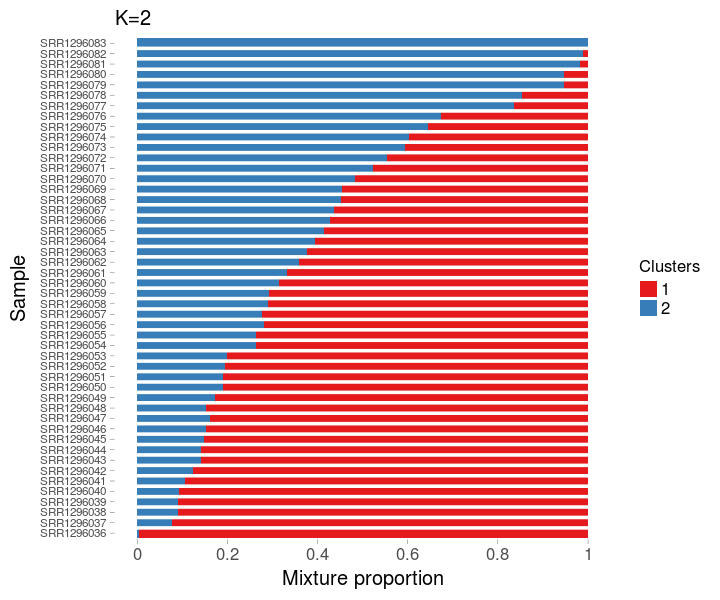

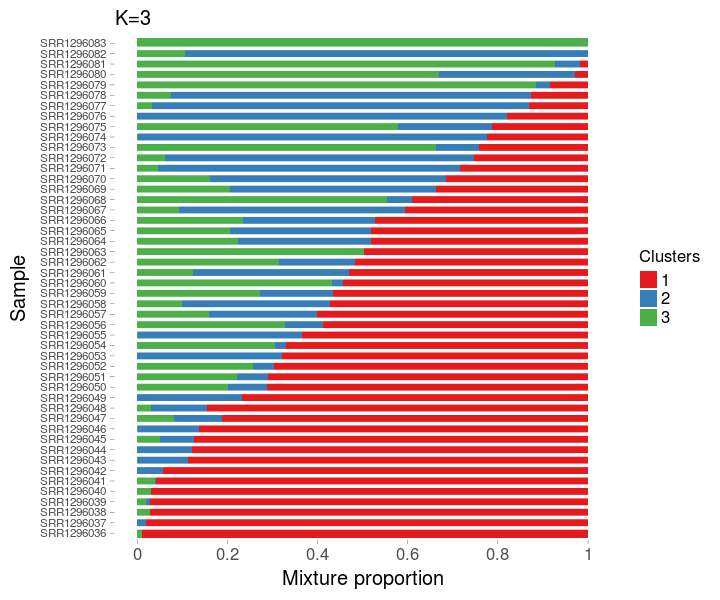

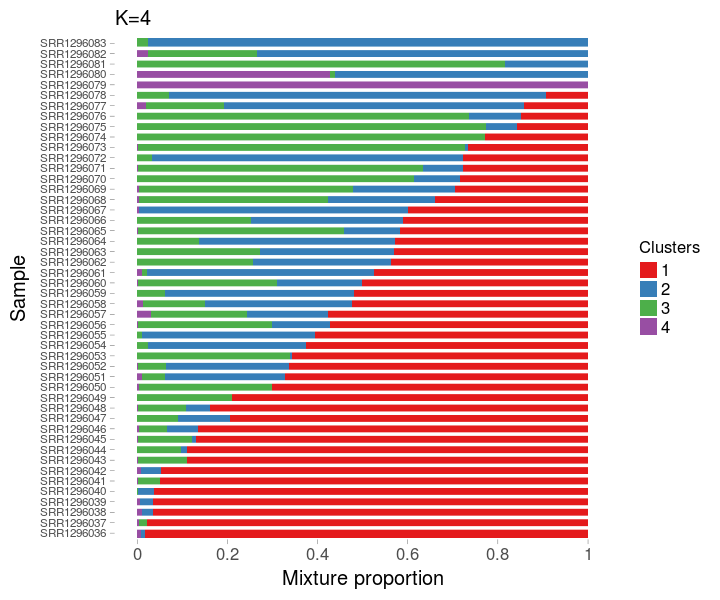

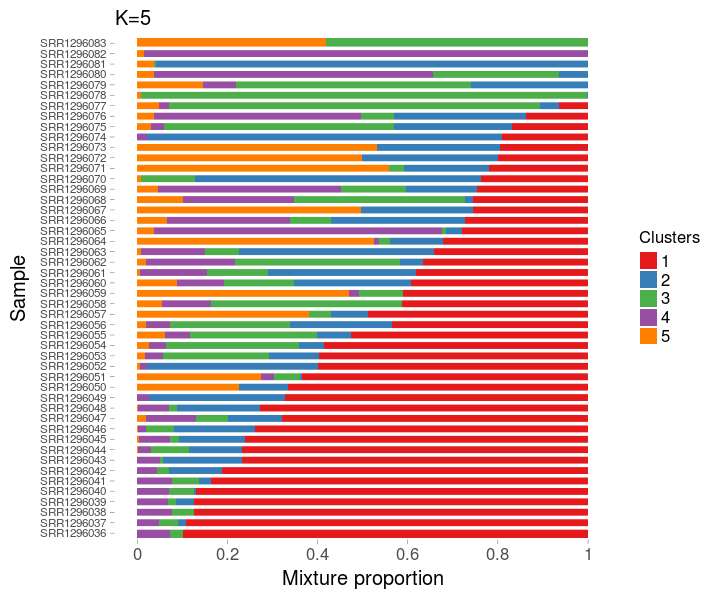

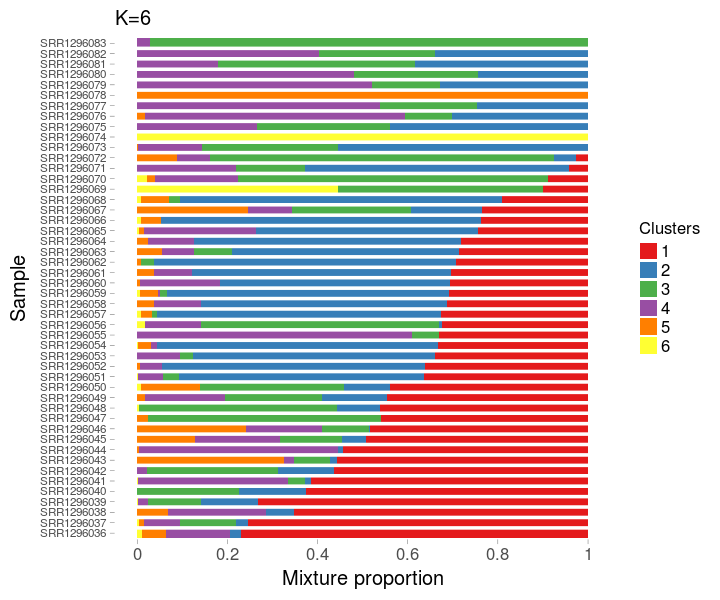

In [96]:
for(k in 2:6){

    # omega
    clust <- paste0('clust_', k)
    omega <- Topic_clus_list[[clust]]$omega
    annotation <- data.frame(sample_id=paste0('X', 1:nrow(omega)),
                             tissue_label=factor(rownames(omega)))
    colnames(omega) <- 1:ncol(omega) 
    
    # plot
    p <- StructureGGplot(omega = omega[do.call(order, c(decreasing = TRUE, 
                                                        data.frame(omega[,1:k]))),],
                         figure_title = paste0('K=', k),
                         annotation = annotation,
                         palette = RColorBrewer::brewer.pal(8, "Set1"),
                         yaxis_label = "Sample",
                         order_sample = TRUE,
                         sample_order_decreasing = TRUE,
                         axis_tick = list(axis_ticks_length = .1,
                                          axis_ticks_lwd_y = .1,
                                          axis_ticks_lwd_x = .1
                                          )) +
         theme(
               axis.title.y=element_text(size=12),
               axis.text.y =element_text(size=7),
               axis.title.x=element_text(size=12),
               axis.text.x =element_text(size=10),
               legend.title=element_text(size=10),
               legend.text=element_text(size=10),
               plot.title = element_text(size=12)
              ) +
         ylab('Mixture proportion') 
    
    print(p)
}